# [Titanic](https://www.kaggle.com/c/titanic/overview) 

* SVM -- 0.794
* PCA -- 0.799 (svm pca降9維度)
* [3% 範本](https://medium.com/@yulongtsai/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f)

In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection # 分割資料模組
import sklearn.neighbors # 鄰進點模組
import sklearn.linear_model # 線性模組
import sklearn.svm # SVM 模組
import sklearn.naive_bayes # 貝氏分類模組
import sklearn.decomposition

%matplotlib inline

### 資料整理 & 展示

In [25]:
train = pd.read_csv('train.csv')
train_Survived = train[['PassengerId', 'Survived']] # y_train
train = train.drop(columns='Survived') # train datas
test = pd.read_csv('test.csv') # test datas
data = pd.concat([train, test]) # 全體資料一起前處理
data = data.set_index('PassengerId') # reset index

submission = pd.read_csv('gender_submission.csv')

In [26]:
data.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [27]:
train_Survived.head(3)

,PassengerId,Survived
0,1,0
1,2,1
2,3,1


In [28]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


### 參數選用

|mark|參數|-|mark|參數|-|
|:---|:---|---:|:---|:---|---:|
|x|PassengerId|乘客編號|x|Survived|是否倖存|
|v|Pclass|     船票等級|x|Name    |乘客姓名|
|v|Sex|        乘客性別|v|Age        |年齡|
|o|SibSp|      堂兄弟妹|o|Parch |父母與小孩|
|x|Ticket|     船票號碼|o|Fare    |船票價格|
|o|Cabin|         船艙|o|Embarked|登入港口|

* marker:
    * v 選用
    * o 考參
    * x 不選用

* 選取參數 ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

### 觀察數據 選用轉換`One-Hot encode`的參數 

* `Pclass`
* `Sex`
* `Cabin`
* `Embarked`

In [29]:
data['ad'] = (data['Age'] > 18).astype(int) * data['Age'].notnull().astype(int)
data['cd'] = (data['Age'] <= 18).astype(int) * data['Age'].notnull().astype(int)
data['Age_nan'] = data.Age.isnull().astype(int)

In [30]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
cols = data.columns
for col in cols:
    print(data[col].value_counts())

3    709
1    323
2    277
Name: Pclass, dtype: int64
Connolly, Miss. Kate                               2
Kelly, Mr. James                                   2
Rice, Mrs. William (Margaret Norton)               1
Minahan, Miss. Daisy E                             1
Plotcharsky, Mr. Vasil                             1
                                                  ..
Devaney, Miss. Margaret Delia                      1
Youseff, Mr. Gerious                               1
Thomas, Mr. Tannous                                1
Ryerson, Mrs. Arthur Larned (Emily Maria Borie)    1
Baclini, Miss. Eugenie                             1
Name: Name, Length: 1307, dtype: int64
male      843
female    466
Name: Sex, dtype: int64
24.00    47
22.00    43
21.00    41
30.00    40
18.00    39
         ..
76.00     1
22.50     1
74.00     1
80.00     1
0.67      1
Name: Age, Length: 98, dtype: int64
0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64
0    1002
1    

### 編碼前 先檢查空值`Nan`, 補上適合的值(補值的細節先放過)

* Age 補上平均值
* Cabin 空值多於, 放棄使用
* Embarked 補上最多的`'S'`

In [31]:
data.isnull().sum()

Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
ad             0
cd             0
Age_nan        0
dtype: int64

In [32]:
age_mean = data.Age.mean()
fake_med = data.Fare.median()

# 補值
data.Age = data.Age.fillna(age_mean)
data.Fare = data.Fare.fillna(fake_med)
# 補上最多值
data.Embarked = data.Embarked.fillna('S')

### 已經沒有空值

In [33]:
cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age_nan', 'ad', 'cd']
data = data[cols]

data.isnull().sum()

Pclass      0
Sex         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Age_nan     0
ad          0
cd          0
dtype: int64

### `Pclass`, `Sex`, `Embarked` 順利編碼

In [34]:
data.Pclass = data.Pclass.astype(np.str) # 艙等 int 修改為 string
data = pd.get_dummies(data)

In [35]:
data.head(3)

,SibSp,Parch,Fare,Age_nan,ad,cd,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,1,0,7.2500,0,1,0,0,0,1,0,1,0,0,1
2,1,0,71.2833,0,1,0,1,0,0,1,0,1,0,0
3,0,0,7.9250,0,1,0,0,0,1,1,0,0,0,1


In [36]:
data.Fare = np.log(data.Fare+1)

### 將`['Age', 'SibSp', 'Parch', 'Fare']` 做正規化
* one-hot 編碼不用正規化 表現更差

In [37]:
cols = ['SibSp', 'Parch', 'Fare']
val = data[cols].values

model = sklearn.preprocessing.StandardScaler().fit(val) # 表現比較好
# model = sklearn.preprocessing.MinMaxScaler().fit(val)
data[cols] = model.transform(val)

In [38]:
data.head(3)

,SibSp,Parch,Fare,Age_nan,ad,cd,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0.481288,-0.445,-0.897786,0,1,0,0,0,1,0,1,0,0,1
2,0.481288,-0.445,1.344455,0,1,0,1,0,0,1,0,1,0,0
3,-0.479087,-0.445,-0.816539,0,1,0,0,0,1,1,0,0,0,1


In [39]:
n = train.shape[0]
X = data.iloc[0:n].values
y = train_Survived.Survived.values
submit_test = data.iloc[n:].values # 輸出資料 預測X

### PCA 視覺化 觀察是否容易分類

In [17]:
X.shape

(891, 14)

10


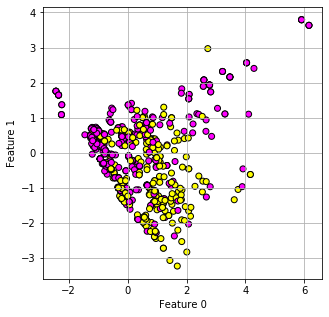

In [18]:
pca = sklearn.decomposition.PCA(n_components=10)
X = pca.fit_transform(X)

fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=y, ec='k', cmap=matplotlib.cm.spring)
ax.grid(True)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

print(X.shape[1])

In [19]:
pca.explained_variance_ratio_

array([0.36061473, 0.19991556, 0.11746939, 0.08835109, 0.07449034,
       0.04766954, 0.04281554, 0.03142851, 0.02068742, 0.0165579 ])

### PCA降維度 & 資料分隔 
* 訓練資料
* 驗證資料

In [52]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=47)

### SVM rbf

In [53]:
svm = sklearn.svm.SVC(gamma='auto')
svm.fit(X_train, y_train)
train_s = svm.score(X_train, y_train)
test_s = svm.score(X_test, y_test)

print('train :', train_s)
print('test  :', test_s)

train : 0.8068862275449101
test  : 0.8161434977578476


### 選用SVM 用上全部資料訓練

In [54]:
svm = sklearn.svm.SVC(gamma='auto')
svm.fit(X, y)

print(svm.score(X, y ))

0.8148148148148148


In [23]:
submission.Survived = svm.predict(pca.transform(submit_test))
submission.to_csv('submission.csv', index=0)